# Laboratorio 7. Autoencoder, Isolation Forest y LOF

In [1]:
from sklearn.datasets import fetch_covtype
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

## Carga de los datos

In [2]:
# Cargar dataset
covtype = fetch_covtype(as_frame=True)  # lo pedimos como DataFrame
X = covtype.data
y = covtype.target  # Cover_Type original (1–7)

# Revisar estructura
print(X.shape)
print(X.head())
print(y.value_counts())

(581012, 54)
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0     2596.0    51.0    3.0                             258.0   
1     2590.0    56.0    2.0                             212.0   
2     2804.0   139.0    9.0                             268.0   
3     2785.0   155.0   18.0                             242.0   
4     2595.0    45.0    2.0                             153.0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                             0.0                            510.0   
1                            -6.0                            390.0   
2                            65.0                           3180.0   
3                           118.0                           3090.0   
4                            -1.0                            391.0   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0          221.0           232.0          148.0   
1          220.0           235.0          151.0   
2          234.0      

## Escalar datos

In [3]:
# Separar numéricas y binarias
X_num = X.iloc[:, :10]     # primeras 10 columnas numéricas
X_bin = X.iloc[:, 10:]     # resto: binarias (0/1)

# Escalar numéricas
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)

# Unir de nuevo
X_scaled = pd.concat([X_num_scaled, X_bin], axis=1)

## Etiquetar

In [4]:
y_binary = np.where(y == 2, 1, 0)  # 1 = normal, 0 = anómalo

# Revisar proporción
pd.Series(y_binary).value_counts()

,count
0,297711
1,283301


## Autocodificador

### División train/val/test

In [6]:
from sklearn.model_selection import train_test_split

# Dividimos train+val vs test (incluyendo normales y anómalos en test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# De X_temp nos quedamos solo con los normales (para entrenar el AE)
X_temp_norm = X_temp[y_temp == 1]

# train y val (solo normales)
X_train, X_val = train_test_split(
    X_temp_norm, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape, " (con normales y anomalías)")

Train: (181312, 54)
Val: (45329, 54)
Test: (116203, 54)  (con normales y anomalías)


### Modelo

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, f1_score

In [8]:
input_dim = X_train.shape[1]

# Definir el modelo
input_layer = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(32, activation="relu")(input_layer)
encoded = layers.Dense(16, activation="relu")(encoded)
bottleneck = layers.Dense(8, activation="relu")(encoded)

# Decoder (simétrico)
decoded = layers.Dense(16, activation="relu")(bottleneck)
decoded = layers.Dense(32, activation="relu")(decoded)
output_layer = layers.Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = keras.Model(inputs=input_layer, outputs=output_layer)

# Compilación con MSE
autoencoder.compile(optimizer="adam", loss="mse")

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Entrenamiento
history = autoencoder.fit(
    X_train,
    X_train,  # se entrena a reconstruir la entrada
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop]
)

Epoch 1/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2210 - val_loss: 0.1287
Epoch 2/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1259 - val_loss: 0.1163
Epoch 3/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1140 - val_loss: 0.1110
Epoch 4/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1110 - val_loss: 0.1098
Epoch 5/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1098 - val_loss: 0.1093
Epoch 6/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1094 - val_loss: 0.1083
Epoch 7/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1081 - val_loss: 0.1074
Epoch 8/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1078 - val_loss: 0.1069
Epoch 9/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1071 - val_loss: 0.1065
Epoch 10/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1067 - val_loss: 0.1063
Epoch 11/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1066 - val_loss: 0.1060
Epoch 12/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

### Métricas

In [9]:
# Predicciones del autoencoder
X_test_pred = autoencoder.predict(X_test)

# Error de reconstrucción (MSE fila por fila)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


5666/5666 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
[[51587  7956]
 [53794  2866]]


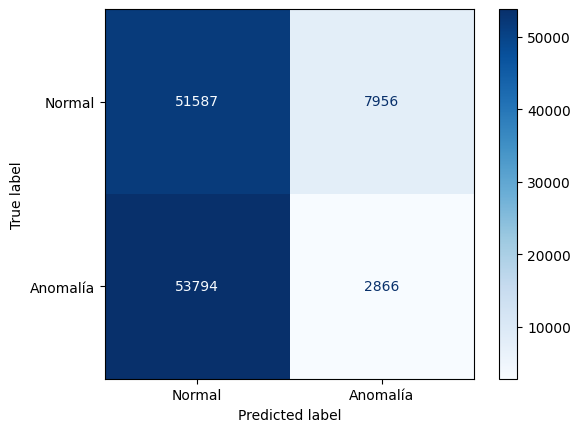

In [15]:
# Calcular umbral (ej: percentil 95 del error en train)
train_pred = autoencoder.predict(X_train)
train_errors = np.mean(np.square(X_train - train_pred), axis=1)
threshold = np.percentile(train_errors, 95)

# Predicciones binarias
y_pred_binary = (reconstruction_errors > threshold).astype(int)  # 1 = anomalía

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Anomalía"])
disp.plot(cmap=plt.cm.Blues)
plt.show()

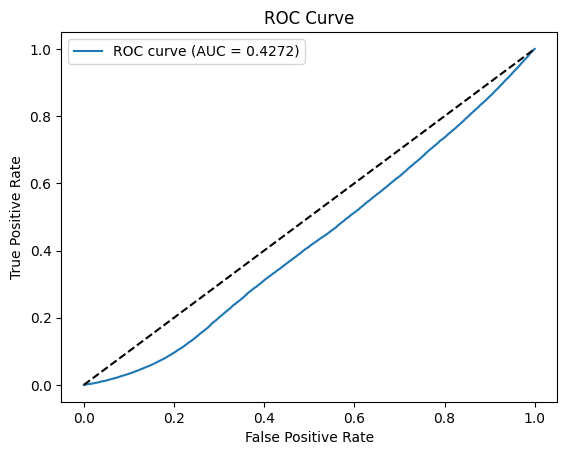

In [11]:
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = roc_auc_score(y_test, reconstruction_errors)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

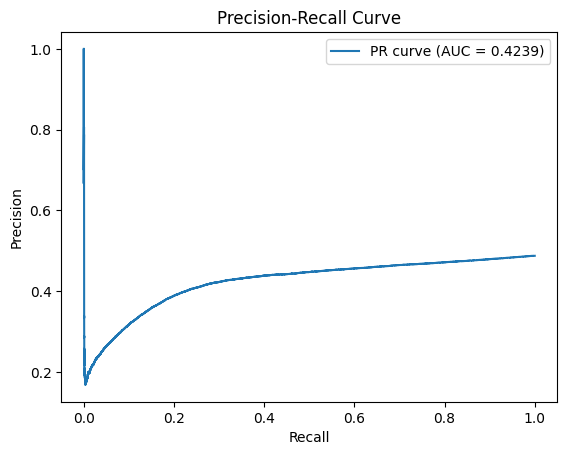

In [12]:
precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)
pr_auc = average_precision_score(y_test, reconstruction_errors)

plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [13]:
f1 = f1_score(y_test, y_pred_binary)
print("F1@umbral:", f1)

F1@umbral: 0.08494116949705106


In [14]:
def precision_at_k(y_true, scores, k):
    # Ordenar por score (descendente)
    idx = np.argsort(scores)[::-1]
    top_k = idx[:k]
    return np.mean(y_true[top_k])

for k in [10, 50, 100]:
    print(f"Precision@{k}: {precision_at_k(y_test, reconstruction_errors, k):.4f}")

Precision@10: 0.7000
Precision@50: 0.6800
Precision@100: 0.3900
